# Benchmark ComBind on PDB ligands

In [3]:
import numpy as np
import os
from glob import glob
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
from benchmark import load_chembl,  benchmark
%matplotlib inline

In [4]:
data = load_chembl('stats6', 'best_affinity')

SLC6A4
BRAF
PYGM
SMO
AR
VDR
MEK1
5HT2B
F11
P00760
CDK2
JAK2
BACE1
ERA
DAT
BRD4
A2AR
PLK1
PTPN1
GLUT1
MGLUR5
PLAU
B2AR
F2
TRPV1
F10
NR3C2
ELANE
NR3C1
MAPK14
HSP90AA1
PDE10A
B1AR
CHK1


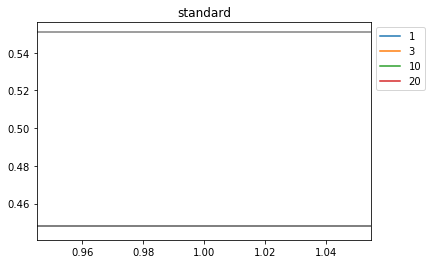

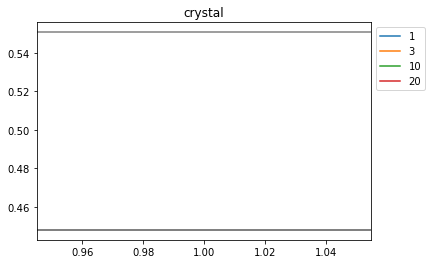

In [7]:
def performance(results):
    x, y = [], []
    for prot, ligs in results.items():
        for lig, (combind, glide, best) in ligs.items():
            x += [glide]
            y += [combind]
    return (sum(x) / float(len(x)), sum(np.array(x) <= 2.0) /  float(len(x)),
            sum(y) / float(len(y)), sum(np.array(y) <= 2.0) /  float(len(y)))

def sweep(data, mode, feature):
    num_ligs = sorted(set(k[0] for k in data[mode].keys()))
    alpha_factors = sorted(set(k[1] for k in data[mode].keys()))
    for n in [1, 3, 10, 20]: #num_ligs:
        performances = []
        for alpha_factor in alpha_factors:
            performances += [performance(data[mode][(n, alpha_factor, feature)])]
        plt.plot(alpha_factors, [p[3] for p in performances], label = n)
        for p in performances:
            plt.axhline(p[1], c = 'grey')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.title(mode)
    plt.show()

sweep(data, 'standard', 'mcss_contact_hbond_sb')
sweep(data, 'crystal',  'mcss_contact_hbond_sb')

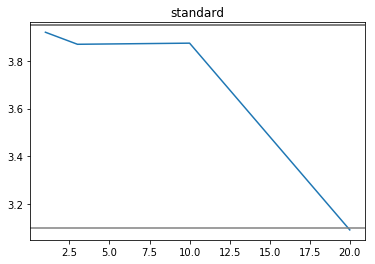

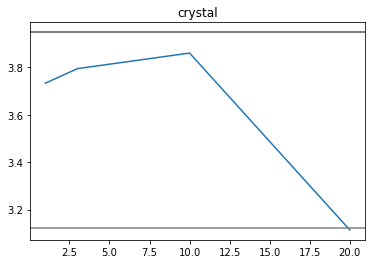

In [8]:
def sweep(data, mode, feature):
    num_ligs = sorted(set(k[0] for k in data[mode].keys()))
    alpha_factor = 1.0
    performances = []
    for n in num_ligs:
        performances += [performance(data[mode][(n, alpha_factor, feature)])]
    plt.plot(num_ligs, [p[2] for p in performances])
    for p in performances:
        plt.axhline(p[0], c = 'grey')
    plt.title(mode)
    plt.show()

sweep(data, 'standard', 'mcss_contact_hbond_sb')
sweep(data, 'crystal',  'mcss_contact_hbond_sb')

491 valid ligands
Ttest_relResult(statistic=0.84373019947461281, pvalue=0.39923189025038108)
ComBind improves pose for 84 of 491 ligands
ComBind degrades pose for 63 of 491 ligands
All Ligands RMSD Glide: 3.94795702037, 0.448065173116
All Ligands RMSD ComBind: 3.87395872802, 0.452138492872


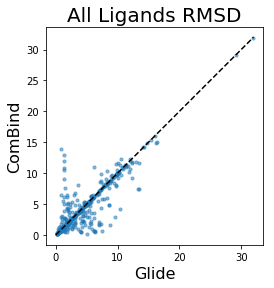

Mean RMSD Glide: 3.8834934983
Mean RMSD ComBind: 3.71531095529


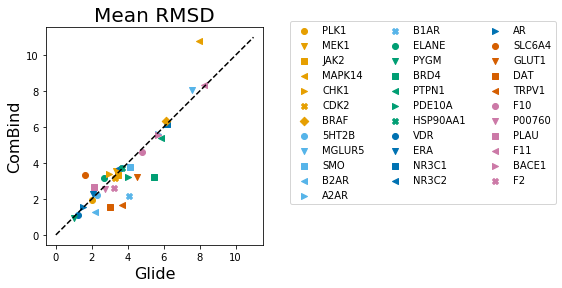

Fraction Near-Native Glide: 0.439011514725
Fraction Near-Native ComBind: 0.466887874717


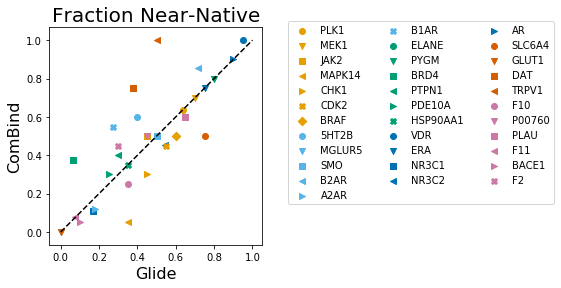

In [16]:
benchmark(data['standard'][(10, 1.0, 'mcss_contact_hbond_sb')])